#### Deep Learning : AI2100

#### HW4

#### Tanmay Goyal- AI20BTECH11021

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision

##### Important pieces of code

In [72]:
def conv(img ,  kernel , stride = 1 , padding = False, nl_act = 'relu' , relu_parameter = 0.5):
    
    # checking for validity of image and kernel sizes
    (W,H,C) = img.shape
    if len(kernel.shape) == 2:
        kernel = kernel.reshape((kernel.shape[0] , kernel.shape[1] , 1))
    if C != kernel.shape[2] or kernel.shape[0] != kernel.shape[1]:
        print("Invalid image or kernel size")
        return False
    
    # checking for validity of non linear activation
    if nl_act not in ['sigmoid' , 'relu' , 'tanh' , 'prelu' , 'none']:
        print("Invalid Non linear activation")
        return False

    k = kernel.shape[0]

    if padding == True:
        pad_size = k-1

        # we have been asked to use reflection padding
        # all the indices have been calculated with care
        padded = np.zeros((W + 2 * pad_size , H + 2 * pad_size , C))

        # copying the image to the center patch
        padded[pad_size : W + pad_size , pad_size : H + pad_size] = img

        # doing reflection padding
        # top and bottom
        padded[:pad_size , :] = np.flip(padded[pad_size + 1 : 2 * pad_size + 1, :] , axis = 0)       # taking reflection
        padded[W + pad_size: , :] = padded[W : W + pad_size, :]
            
        # doing reflection padding
        # sides
        padded[: , :pad_size] = np.flip(padded[: , pad_size + 1 : 2 * pad_size + 1] , axis = 1)     # taking reflection
        padded[: ,H + pad_size:] = padded[: , H : H + pad_size]
        
        
        # flipping kernel
        kernel = kernel[::-1 , ::-1 , :]
    
        # doing the convolution
        output = np.zeros((np.ceil((W + pad_size)/stride).astype(int) ,np.ceil((H + pad_size)/stride).astype(int)))

        for i in range(0,output.shape[0]):
            for j in range(0,output.shape[1]):
                pad_patch = padded[i * stride : i * stride + k , j * stride : j * stride + k , :]
                output[i][j] = np.sum(np.multiply(pad_patch,kernel)) 
    
        # dividing output by sum of kernel
        if(kernel.sum() != 0):
            output = output / kernel.sum()

    
    else:   # padded = False

        # flipping kernel
        kernel = kernel[::-1 , ::-1 , :]
    
        # doing the convolution
        output = np.zeros((np.ceil((W - k + 1)/stride).astype(int) ,np.ceil((H - k + 1)/stride).astype(int)))

        for i in range(0,output.shape[0]):
            for j in range(0,output.shape[1]):
                img_patch = img[i * stride : i * stride + k , j * stride : j * stride + k , :]
                output[i][j] = np.sum(np.multiply(img_patch,kernel)) 
    
        # dividing output by sum of kernel
        if(kernel.sum() != 0):
            output = output / kernel.sum()

    
    # applying non linear activations
    if nl_act == 'sigmoid':
        output_nl = 1 / (1 + np.exp(-output))
    
    elif nl_act == 'relu':
        
        output_nl = np.zeros(output.shape)
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i][j] >= 0:
                    output_nl[i][j] = output[i][j]

    elif nl_act == 'tanh':
        output_nl = (np.exp(output) - np.exp(-output))/ (np.exp(output) + np.exp(-output))

    elif nl_act == 'prelu':           # parametric relu
        output_nl = np.zeros(output.shape)
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i][j] >= 0:
                    output_nl[i][j] = output[i][j]
                else:
                    output_nl[i][j] = output[i][j] * relu_parameter

    else:
        output_nl = output
    return output_nl


In [73]:
def pooling(conv_out , size , pool_type = 'max', stride = 1):
    
    # checking validity of type of pooling
    if pool_type not in ['max' , 'avg' , 'norm']:
        print("Invalid Pooling type")
        return False

    if len(conv_out.shape) == 3:
        (W,H,C) = conv_out.shape

        # assuming size is same across both dimensions
        output = np.zeros((np.ceil((W - size + 1) / stride).astype(int) , np.ceil((H - size + 1) / stride).astype(int) , C))
        # doing the pooling

        for c in range(C):
            layer = conv_out[: , : , c]
            
            for i in range(output.shape[0]):
                for j in range(output.shape[1]):
                    patch = layer[i * stride : i * stride + size , j * stride : j * stride + size]
                    
                    if pool_type == 'max':
                        output[i][j][c] = np.max(patch)
                    elif pool_type == 'avg':
                        output[i][j][c] = np.sum(patch) / patch.size
                    else:
                        output[i][j][c] = np.sqrt(np.sum(np.power(patch,2)))    # assuming 2-norm

    else:       # len(shape) == 2
        (W,H) = conv_out.shape

        # assuming size is same across both dimensions
        output = np.zeros((np.ceil((W - size + 1) / stride).astype(int) , np.ceil((H - size + 1) / stride).astype(int)))
        # doing the pooling

        layer = conv_out[: , :]
        
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                patch = layer[i * stride : i * stride + size , j * stride : j * stride + size]
                
                if pool_type == 'max':
                    output[i][j]= np.max(patch)
                elif pool_type == 'avg':
                    output[i][j]= np.sum(patch) / patch.size
                else:
                    output[i][j] = np.sqrt(np.sum(np.power(patch,2)))    # assuming 2-norm

    return output


In [74]:
def conv_layer(inp , kernels , stride = 1 , padding = False , nl ='relu'):
    # print(kernels.shape)
    output = []

    for i in range(kernels.shape[-1]):
        if len(kernels.shape)==3: 
            kernel = kernels[: , : , i]
        else:       # length = 4
            kernel = kernels[: , : , : , i]

        # print(inp.shape)
        # print(kernel.shape)

        x = conv(inp , kernel , stride , padding , nl)
        output.append(x)

    output_final = np.stack(output , axis = len(x.shape))
        
    return output_final

In [101]:
def pooling_layer(inp , size , pool_type , stride):

    o = pooling(inp , size , pool_type , stride)
    return o

In [76]:
def unravel(inp , flat_matrix):
    unraveled = np.ravel(inp)
    output = flat_matrix @ unraveled
    return output

In [77]:
def MLP(inp, n_hidden , nl, w_input_hidden , w_hidden_output):
    #  np.random.seed(123)

    # INPUT LAYER
    # accounting for bias term
    inp = inp.reshape(inp.shape[0],)
    inp_dash = np.hstack((1 , inp))
    

    # HIDDEN LAYERS
    z_dash = inp_dash
    for i in range(n_hidden):

        a = w_input_hidden @ z_dash
        
        # applying non linearities
        if nl == 'sigmoid':
            z = 1 / (1 + np.exp(-a))

        elif nl == 'relu':
            z = np.zeros(a.shape)
            for i in range(a.shape[0]):
                    if a[i] >= 0:
                        z[i] = a[i]

        elif nl == 'tanh':
            z = (np.exp(a) - np.exp(-a))/ (np.exp(a) + np.exp(-a))

        # appending 1 to z for bias term again
        z_dash = np.hstack((1,z))


    # OUTPUT LAYER
    pre_output_dash = z_dash
    output = w_hidden_output @ pre_output_dash
    # since softmax(x) = softmax(x+c)
    output = output - np.max(output)
    softmax_output = np.exp(output) / np.sum(np.exp(output))

    return pre_output_dash, softmax_output

In [78]:
def feed_forward(inp , kernels_l1 , kernels_l2 , w_inner_hidden , w_hidden_output):
    
    # Convolution layer of 4 kernels of size 5 x 5 and ReLu activation
    o1 = conv_layer(inp , kernels = kernels_l1 , stride = 1)

    # max pooling layer of size 2 x 2 with stride of 2
    o2 = pooling_layer(o1 , 2 , 'max' , 2)
    
    # convolution layer with 4 kernels of size 5 x 5 x 4 and ReLu Activation.
    o3 = conv_layer(o2 , kernels = kernels_l2)
    
    # Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
    o4 = pooling_layer(o3 , 2 , 'max' , 2)

    # Flattening layer with flattening matrix as identity matrix
    o5 = unravel(o4 , np.identity(o4.ravel().shape[0]))

    # Perceptron layer
    hidden_final , o_final = MLP(o5 , 1 , 'relu' , w_inner_hidden , w_hidden_output)

    return o1 , o2 , o3 , o4 , o5 , hidden_final , o_final

##### Loading the Data

In [79]:
# loading the datasets

transformation = transforms.Compose([transforms.Resize((28)) , transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(root = './data', train = True, download = True , transform =transformation)
test_data = torchvision.datasets.MNIST(root = './data', train = False, download = True , transform =transformation)


In [80]:
# preparing our training and testing data

train_loader = DataLoader(dataset = train_data , batch_size = 2000 )
test_loader  =  DataLoader(dataset = test_data, batch_size = 2000 )

In [102]:
training_data = []
testing_data = []

examples = iter(train_loader)
example_data_train, example_targets_train = examples.next()
example_targets_train = example_targets_train.numpy()

examples = iter(test_loader)
example_data_test, example_targets_test = examples.next()
example_targets_test = example_targets_test.numpy()

lengths_train = [0 for i in range(10)]      # to check if the number of images for each class is 100
lengths_test = [0 for i in range(10)]      # to check if the number of images for each class is 10


# appending tuples of data vector and true labels 
for counter in range(2000):
    inp = example_data_train[counter][0].numpy() 
    target = example_targets_train[counter]
    if lengths_train[target] <= 99:         # to ensure we donot go beyond the specified limit of images per class
        training_data.append((inp.reshape(28,28,1),target))
        lengths_train[target] += 1

    if np.sum(np.array(lengths_train)) == 1000:
        break
    
for counter in range(2000):
    inp = example_data_test[counter][0].numpy() 
    target = example_targets_test[counter]
    if lengths_test[target] <= 9:           # to ensure we donot go beyond the specified limit of images per class
        testing_data.append((inp.reshape(28,28,1), target))
        lengths_test[target] += 1

    if np.sum(np.array(lengths_test)) == 100:
        break


In [82]:
# defining the cross entropy loss
def ce_loss(softmax_output, ground_truth):
    if softmax_output[ground_truth] != 0:
        return -np.log2(softmax_output[ground_truth])
    else:
        return 0

In [83]:
def gradients_MLP(input ,w_inner_hidden , w_hidden_output , hidden_output , output , one_hot_output):
    # wrt weights between hidden and output layer 
    beta_grads = ((1-output) * one_hot_output).reshape((n_output,1)) @ hidden_output.reshape((n_hidden+1,1)).T
    beta_grads = -beta_grads

    # relu derivative
    hidden_output_derivatives = np.array([1 if x >= 0 else 0 for x in hidden_output[1:]]).reshape(n_hidden,1)       
    
    # wrt weights between input and hidden layer
    priors = ((1-output) * one_hot_output).reshape((n_output,1)).T @ w_hidden_output[:,1:]
    priors = priors.T * hidden_output_derivatives
    input = np.hstack((1,input))        # appending the 1 to account for bias
    alpha_grads = priors @ input.reshape(n_input + 1,1).T
    alpha_grads = -alpha_grads
    
    # wrt inputs for backprop to next layer
    priors = ((1-output) * one_hot_output).reshape((n_output,1)).T @ w_hidden_output[:,1:]
    priors = priors.T * hidden_output_derivatives
    input_grad = priors.T @ w_inner_hidden[: , 1:]
    input_grad = -input_grad.T

    return beta_grads, alpha_grads, input_grad

In [103]:
def pooling_backprop(prev_layer_grad , pooled_i):
   
    # done assuming everything was max-pooled
    if len(prev_layer_grad.shape)  == 2:
        backprop_grads = np.zeros(pooled_i.shape)

        # the gradient only backpropogates through the maximmum element
        # so we try to find the maximum element through each patch, propogate the gradient through there, 
        # and assign zero gradient to the rest of the elements
        for i in range(prev_layer_grad.shape[0]):
            for j in range(prev_layer_grad.shape[1]):
                patch = pooled_i[i * 2 : i * 2 + 2 , j * 2 : j * 2 + 2]
                
                # finding which element was the maximum one
                if patch[0][0] == np.max(patch):
                    backprop_grads[i*2][j*2] = prev_layer_grad[i][j] 
                elif patch[0][1] == np.max(patch):
                    backprop_grads[i*2][j*2 + 1] = prev_layer_grad[i][j] 
                elif patch[1][0] == np.max(patch):
                    backprop_grads[i*2 + 1][j*2] = prev_layer_grad[i][j] 
                else:
                    backprop_grads[i*2 + 1][j*2 + 1] = prev_layer_grad[i][j] 

        return backprop_grads
    
    else:
        backprop_grads = np.zeros(pooled_i.shape)
        C = pooled_i.shape[2]
        for c in range(C):
            for i in range(prev_layer_grad.shape[0]):
                for j in range(prev_layer_grad.shape[1]):
                    patch = pooled_i[i * 2 : i * 2 + 2 , j * 2 : j * 2 + 2 , c]
                    
                    # finding which element was the maximum one
                    if patch[0][0] == np.max(patch):
                        backprop_grads[i*2][j*2][c] = prev_layer_grad[i][j][c]
                    elif patch[0][1] == np.max(patch):
                        backprop_grads[i*2][j*2 + 1][c] = prev_layer_grad[i][j][c]
                    elif patch[1][0] == np.max(patch):
                        backprop_grads[i*2 + 1][j*2][c] = prev_layer_grad[i][j][c] 
                    else:
                        backprop_grads[i*2 + 1][j*2 + 1][c] = prev_layer_grad[i][j][c] 

        return backprop_grads


In [85]:
def conv_backprop(prev_layer_grad, input , kernels):
    prev_grads = prev_layer_grad
    
    # taking reference from Vineeth Sir's NPTEL videos
    # grad wrt weights  = previous grad convolved with input
    # grad wrt input = previous grad convolved with flipped kernels with padding

    if len(kernels.shape) == 4:
        kernels = kernels[::-1 , ::-1 , : , :]
    else:
        kernels = kernels[::-1 , ::-1 , :]

    if len(kernels.shape) == 4:
        grad_weights = []
        for c in range(prev_grads.shape[-1]):
            kernel = prev_grads[: , : , c]
            if len(kernel.shape) == 2:
                kernel = kernel.reshape((kernel.shape[0] , kernel.shape[1] , 1))
            array = []
            for x in range(kernel.shape[-1]):            
                inp = input[:,:,x]
                if len(inp.shape) == 2:
                    inp = inp.reshape((inp.shape[0] , inp.shape[1] , 1))
                o = conv(inp , kernel , nl_act = 'none')
                array.append(o)

            array = np.stack(np.array(array) , axis = len(o.shape))
            array = np.array(array)
            grad_weights.append(array)

        grad_weights = np.stack(np.array(grad_weights) , axis = len(array.shape))
    
    else:
        grad_weights = []
        for c in range(prev_grads.shape[-1]):
            kernel = prev_grads[: , : , c]
            if len(kernel.shape) == 2:
                kernel = kernel.reshape((kernel.shape[0] , kernel.shape[1] , 1))
            array = []
            for x in range(kernel.shape[-1]):            
                inp = input[:,:,x]
                if len(inp.shape) == 2:
                    inp = inp.reshape((inp.shape[0] , inp.shape[1] , 1))
                o = conv(inp , kernel , nl_act = 'none')
                grad_weights.append(o)

        grad_weights = np.stack(np.array(grad_weights) , axis = len(o.shape))

    grad_inputs = []
    if len(kernels.shape) == 4:
        for c in range(kernels.shape[-1]):
            if len(kernels.shape) == 4:
                kernel = kernels[: , : ,  : ,c]
            else:
                kernel = kernels[: , : ,c]
            o = conv(prev_grads , kernel  , padding = True , nl_act = 'none')
            grad_inputs.append(o)
            
        grad_inputs = np.stack(np.array(grad_inputs) , axis = len(o.shape))         

    else:
        grad_inputs = conv(prev_grads , kernels  , padding = True , nl_act = 'none')

    return grad_weights , grad_inputs

In [86]:
# defining constants and random weight initialisation
np.random.seed(100)

epochs = 15
batch_size = 40
n_input = 64
n_hidden = 49
n_output = 10

kernels_l1 = []
for i in range(4):
    kernels_l1.append(np.random.random((5,5)))
kernels_l1 = np.stack(np.array(kernels_l1),axis = 2)

kernels_l2 = []
for i in range(4):
    kernels_l2.append(np.random.random((5,5,4)))
kernels_l2 = np.stack(np.array(kernels_l2),axis = 2)

w_input_hidden = np.random.random((n_hidden , n_input + 1))
w_hidden_output = np.random.random((n_output , n_hidden + 1))

In [87]:
def vanilla_sgd (og_weights , updates , lr = 0.001 ):
    og_weights = [og_weights[i] - lr * updates[i] for i in range(len(og_weights))] 

    return og_weights   

In [88]:
def momentum(og_weights, v_init , g_init , loss_batch , lr = 0.001 , alpha = 0.9 ):
    intermediate = [lr * loss_batch * g_init[i] for i in range(len(g_init))]

    v_new = [alpha * v_init[i] - intermediate[i] for i in range(len(v_init))]
    
    og_weights = [og_weights[i] + v_new[i] for i in range(len(og_weights))]

    return v_new  , og_weights

In [97]:
def clip(matrix):
    # to ensure square roots of negative numbers does not take place for rmsprop, we replace negative gradients with zero
    return (matrix + np.abs(matrix))/2

In [98]:
def rmsprop(og_weights , updates_new , lr = 0.001 , rho = 0.9):
    term1 = [rho * x for x in updates_new]
    term2 = [(1-rho) * np.power(x,2) for x in updates_new]
    delta_val = 0.0001                                          # stabilising factor to ensure denomuinator does not contain zero
    delta = [np.ones(x.shape) * delta_val for x in updates_new]

    g_new = [term1[i] + term2[i] for i in range(len(term1))]
    term3 = [-1 * lr/np.power(delta[i] + clip(g_new[i]) ,0.5) for i in range(len(g_new))]
    delta_theta = [np.multiply(term3[i],updates_new[i]) for i in range(len(term3))]

    og_weights = [og_weights[i] + delta_theta[i] for i in range(len(og_weights))]

    return og_weights


In [93]:
def train(training_data , epochs , batch_size , sgd_variant , kernels_l1 , kernels_l2 , w_inner_hidden , w_hidden_output):
    np.random.seed(123)
    train_loss = []
    test_loss = []
   
    # setting up initial terms for velocity
    v1_init = np.zeros((kernels_l1.shape))
    v2_init = np.zeros((kernels_l2.shape))
    v3_init = np.zeros((w_inner_hidden.shape))
    v4_init = np.zeros((w_hidden_output.shape))
    v_init = [v1_init , v2_init , v3_init , v4_init]


    for e in range(epochs):
        print("Epoch {}".format(e+1))
        np.random.shuffle(training_data)
        n_images = 0            # count of images inserted per batch
        loss_batch = 0          # loss per batch
        beta_updates = 0        # updates for weights between output and hidden layer    
        alpha_updates = 0       # updates for weights betweemn hidden and inner layer
        kernel_l2_updates = 0   # updates for kernel weights for the second convolutional layer
        kernel_l1_updates = 0   # updates for kernel weights for the first convolutional layer

        # starting to pass the training data
        for i in range(len(training_data)):
            outputs = feed_forward(training_data[i][0] , kernels_l1 , kernels_l2 , w_input_hidden , w_hidden_output)
            output = outputs[-1]
            hidden_output = outputs[-2]
            o5 = outputs[-3]
            o4 = outputs[-4]
            o3 = outputs[-5]
            o2 = outputs[-6]
            o1 = outputs[0]
            ground_truth = training_data[i][1]
            one_hot_output = np.array([1 if j == ground_truth else 0 for j in range(10)])
            loss_batch += ce_loss(output , ground_truth)
            inp = o5

            # backpropogating
            beta_grad , alpha_grad, input_grad = gradients_MLP(inp  ,w_input_hidden ,  w_hidden_output , hidden_output , output , one_hot_output)
            beta_updates += beta_grad
            alpha_updates += alpha_grad
            input_grad = input_grad.reshape(o4.shape)
            gradients_to_conv_layer2 = pooling_backprop(input_grad , o3)
            l2_updates , input_grad_conv_l2 = conv_backprop(gradients_to_conv_layer2 , o2 , kernels_l2)
            kernel_l2_updates += l2_updates
            gradients_to_conv_layer1 = pooling_backprop(input_grad_conv_l2 , o1)
            l1_updates , _ = conv_backprop(gradients_to_conv_layer1 , training_data[i][0].reshape((28,28,1)) , kernels_l1)
            kernel_l1_updates += l1_updates
           
            # checking if one batch has been done, which means we update our parameters
            if n_images % batch_size == 0 and n_images != 0:
                beta_updates /= batch_size          # averaging gradients over batch
                alpha_updates /= batch_size         # averaging gradients over batch
                kernel_l2_updates /= batch_size     # averaging gradients over batch
                kernel_l1_updates /= batch_size     # averaging gradients over batch
                loss_batch /= batch_size            # averaging gradients over batch
                
                # compiling all out parametres and updates for the parameters for ease
                og_weights = [kernels_l1 , kernels_l2 , w_inner_hidden , w_hidden_output]
                updates_new = [kernel_l1_updates, kernel_l2_updates , alpha_updates , beta_updates]
                
                if sgd_variant == "vanilla":
                    og_weights = vanilla_sgd(og_weights , updates_new , lr = 0.001)
                
                elif sgd_variant == "momentum":
                    v_new , og_weights = momentum(og_weights, v_init , updates_new , loss_batch , lr = 0.001 , alpha = 0.9 )
                    v_init = v_new      # keeping track of previous velocity

                elif sgd_variant == "rmsprop":
                    og_weights = rmsprop(og_weights , updates_new , lr = 0.001 , rho = 0.9)

                else:
                    print("Invalid SGD variant")
                    return False

                #unpacking the og_weights
                kernels_l1 = og_weights[0]
                kernels_l2 = og_weights[1]
                w_inner_hidden = og_weights[2]
                w_hidden_output = og_weights[3]
                
                # resetting update variables
                kernel_l1_updates = 0
                kernel_l2_updates = 0
                alpha_updates = 0
                beta_updates = 0
                loss_batch = 0

            
            n_images += 1
            

        # calculating training_loss
        print("Calculating training loss")
        loss = 0
        for i in range(len(training_data)):
            outputs = feed_forward(training_data[i][0].reshape(28,28,1) , kernels_l1 , kernels_l2 , w_input_hidden , w_hidden_output)
            output = outputs[-1]
            ground_truth = training_data[i][1]
            one_hot_output = np.array([1 if j == ground_truth else 0 for j in range(10)])
            loss+=ce_loss(output, ground_truth)
        loss = loss/1000
        train_loss.append(loss)

        # calculating testing loss
        print("Calculating Test loss")
        loss = 0
        for i in range(len(testing_data)):
            outputs = feed_forward(testing_data[i][0].reshape(28,28,1) , kernels_l1 , kernels_l2 , w_input_hidden , w_hidden_output)
            output = outputs[-1]
            ground_truth = testing_data[i][1]
            one_hot_output = np.array([1 if j == ground_truth else 0 for j in range(10)])
            loss+=ce_loss(output, ground_truth)
        loss = loss/1000
        test_loss.append(loss)

    
    # calculating accuracy
    accuracy = 0
    for i in range(len(testing_data)):
        outputs = feed_forward(testing_data[i][0].reshape(28,28,1) , kernels_l1 , kernels_l2 , w_input_hidden , w_hidden_output)
        output = outputs[-1]
        pred_output = 0
        for i in range(len(output)):
            if output[i] == np.max(output):
                pred_output = i
        ground_truth = testing_data[i][1]
        if pred_output == ground_truth:
            accuracy += 1
    
    accuracy /= 1000
    print("Accuracy is {}".format(accuracy))


    # plotting erros vs epoch
    x = [i for i in range(1,16)]
    plt.plot(x , train_loss , 'r-' , label = "Training loss")
    plt.plot(x , test_loss , 'b-' , label = "Testing loss")
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.title("Epochs vs Error")
    plt.show()
            

##### Vanilla SGD for batch size = 50, 100

Epoch 1
Calculating training loss
Calculating Test loss
Epoch 2
Calculating training loss
Calculating Test loss
Epoch 3
Calculating training loss
Calculating Test loss
Epoch 4
Calculating training loss
Calculating Test loss
Epoch 5
Calculating training loss
Calculating Test loss
Epoch 6
Calculating training loss
Calculating Test loss
Epoch 7
Calculating training loss
Calculating Test loss
Epoch 8
Calculating training loss
Calculating Test loss
Epoch 9
Calculating training loss
Calculating Test loss
Epoch 10
Calculating training loss
Calculating Test loss
Epoch 11
Calculating training loss
Calculating Test loss
Epoch 12
Calculating training loss
Calculating Test loss
Epoch 13
Calculating training loss
Calculating Test loss
Epoch 14
Calculating training loss
Calculating Test loss
Epoch 15
Calculating training loss
Calculating Test loss
Accuracy is 0.0


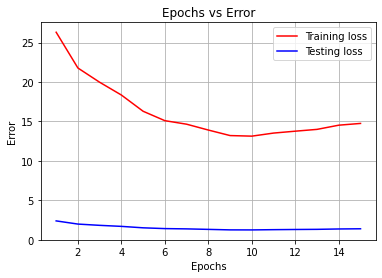

In [94]:
# defining constants and random weight initialisation
np.random.seed(213)

epochs = 15
batch_size = 40
n_input = 64
n_hidden = 49
n_output = 10

kernels_l1 = []
for i in range(4):
    kernels_l1.append(np.random.random((5,5)))
kernels_l1 = np.stack(np.array(kernels_l1),axis = 2)
# print(kernels_l1.shape)

kernels_l2 = []
for i in range(4):
    kernels_l2.append(np.random.random((5,5,4)))
kernels_l2 = np.stack(np.array(kernels_l2),axis = 2)

w_input_hidden = np.random.random((n_hidden , n_input + 1))
w_hidden_output = np.random.random((n_output , n_hidden + 1))


# VANILLA SGD FOR BATCH SIZE 50
train(training_data , 15 , 50 , "vanilla", kernels_l1 , kernels_l2 , w_input_hidden , w_hidden_output)

Epoch 1
Calculating training loss
Calculating Test loss
Epoch 2
Calculating training loss
Calculating Test loss
Epoch 3
Calculating training loss
Calculating Test loss
Epoch 4
Calculating training loss
Calculating Test loss
Epoch 5
Calculating training loss
Calculating Test loss
Epoch 6
Calculating training loss
Calculating Test loss
Epoch 7
Calculating training loss
Calculating Test loss
Epoch 8
Calculating training loss
Calculating Test loss
Epoch 9
Calculating training loss
Calculating Test loss
Epoch 10
Calculating training loss
Calculating Test loss
Epoch 11
Calculating training loss
Calculating Test loss
Epoch 12
Calculating training loss
Calculating Test loss
Epoch 13
Calculating training loss
Calculating Test loss
Epoch 14
Calculating training loss
Calculating Test loss
Epoch 15
Calculating training loss
Calculating Test loss
Accuracy is 0.015


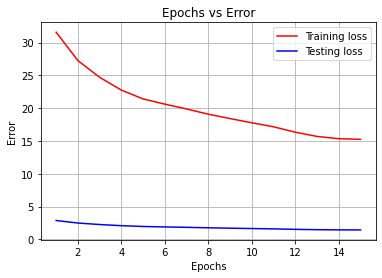

In [25]:
# defining constants and random weight initialisation
np.random.seed(213)

epochs = 15
batch_size = 40
n_input = 64
n_hidden = 49
n_output = 10

kernels_l1 = []
for i in range(4):
    kernels_l1.append(np.random.random((5,5)))
kernels_l1 = np.stack(np.array(kernels_l1),axis = 2)
# print(kernels_l1.shape)

kernels_l2 = []
for i in range(4):
    kernels_l2.append(np.random.random((5,5,4)))
kernels_l2 = np.stack(np.array(kernels_l2),axis = 2)

w_input_hidden = np.random.random((n_hidden , n_input + 1))
w_hidden_output = np.random.random((n_output , n_hidden + 1))


# VANILLA SGD FOR BATCH SIZE 100
train(training_data , 15 , 100 , "vanilla", kernels_l1 , kernels_l2 , w_input_hidden , w_hidden_output)

##### Momentum

Epoch 1
Calculating training loss
Calculating Test loss
Epoch 2
Calculating training loss
Calculating Test loss
Epoch 3
Calculating training loss
Calculating Test loss
Epoch 4
Calculating training loss
Calculating Test loss
Epoch 5
Calculating training loss
Calculating Test loss
Epoch 6
Calculating training loss
Calculating Test loss
Epoch 7
Calculating training loss
Calculating Test loss
Epoch 8
Calculating training loss
Calculating Test loss
Epoch 9
Calculating training loss
Calculating Test loss
Epoch 10
Calculating training loss
Calculating Test loss
Epoch 11
Calculating training loss
Calculating Test loss
Epoch 12
Calculating training loss
Calculating Test loss
Epoch 13
Calculating training loss
Calculating Test loss
Epoch 14
Calculating training loss
Calculating Test loss
Epoch 15
Calculating training loss
Calculating Test loss
Accuracy is 0.0


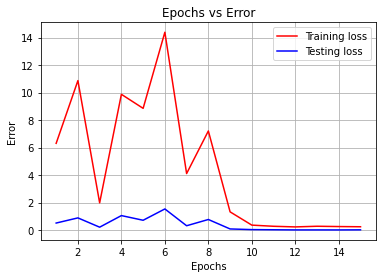

In [26]:
# defining constants and random weight initialisation
np.random.seed(213)

epochs = 15
batch_size = 40
n_input = 64
n_hidden = 49
n_output = 10

kernels_l1 = []
for i in range(4):
    kernels_l1.append(np.random.random((5,5)))
kernels_l1 = np.stack(np.array(kernels_l1),axis = 2)
# print(kernels_l1.shape)

kernels_l2 = []
for i in range(4):
    kernels_l2.append(np.random.random((5,5,4)))
kernels_l2 = np.stack(np.array(kernels_l2),axis = 2)

w_input_hidden = np.random.random((n_hidden , n_input + 1))
w_hidden_output = np.random.random((n_output , n_hidden + 1))


# MOMENTUM FOR BATCH SIZE 50
train(training_data , 15 , 50 , "momentum", kernels_l1 , kernels_l2 , w_input_hidden , w_hidden_output)

Epoch 1
Calculating training loss
Calculating Test loss
Epoch 2
Calculating training loss
Calculating Test loss
Epoch 3
Calculating training loss
Calculating Test loss
Epoch 4
Calculating training loss
Calculating Test loss
Epoch 5
Calculating training loss
Calculating Test loss
Epoch 6
Calculating training loss
Calculating Test loss
Epoch 7
Calculating training loss
Calculating Test loss
Epoch 8
Calculating training loss
Calculating Test loss
Epoch 9
Calculating training loss
Calculating Test loss
Epoch 10
Calculating training loss
Calculating Test loss
Epoch 11
Calculating training loss
Calculating Test loss
Epoch 12
Calculating training loss
Calculating Test loss
Epoch 13
Calculating training loss
Calculating Test loss
Epoch 14
Calculating training loss
Calculating Test loss
Epoch 15
Calculating training loss
Calculating Test loss
Accuracy is 0.0


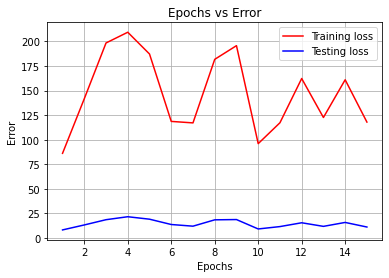

In [99]:
# defining constants and random weight initialisation
np.random.seed(213)

epochs = 15
batch_size = 40
n_input = 64
n_hidden = 49
n_output = 10

kernels_l1 = []
for i in range(4):
    kernels_l1.append(np.random.random((5,5)))
kernels_l1 = np.stack(np.array(kernels_l1),axis = 2)
# print(kernels_l1.shape)

kernels_l2 = []
for i in range(4):
    kernels_l2.append(np.random.random((5,5,4)))
kernels_l2 = np.stack(np.array(kernels_l2),axis = 2)
w_input_hidden = np.random.random((n_hidden , n_input + 1))
w_hidden_output = np.random.random((n_output , n_hidden + 1))


# MOMENTUM FOR BATCH SIZE 50
train(training_data , 15 , 50 , "rmsprop", kernels_l1 , kernels_l2 , w_input_hidden , w_hidden_output)